<a href="https://colab.research.google.com/github/nicoleolivetto/Stage-Tesi/blob/main/Tesi/LSTMVeneto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

covid_ds = pd.read_csv("covid_ds.csv")

In [ ]:

filtered_covid_ds = covid_ds[covid_ds['Region_name'] == 'Veneto'].copy()


In [ ]:
# Convert 'Date' to datetime
filtered_covid_ds['Date'] = pd.to_datetime(filtered_covid_ds['Date'])

# Normalize numeric columns
numeric_columns = ['latitude', 'longitude', 'hospitalized_with_symptoms', 'intensive_care_petients',
                    'total_hospitalized_patients', 'home_isolation', 'current_positive_cases',
                    'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases',
                    'tests_performed']

scaler = MinMaxScaler()
filtered_covid_ds.loc[:, numeric_columns] = scaler.fit_transform(filtered_covid_ds.loc[:, numeric_columns])

In [ ]:
covid_ds

,Unnamed: 0,Date,Region_code,Region_name,latitude,longitude,hospitalized_with_symptoms,intensive_care_petients,total_hospitalized_patients,home_isolation,current_positive_cases,change_in_total_positives,new_positive_cases,recovered,deceased,total_cases,tests_performed
0,0,2020-02-24T18:00:00,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,0,5
1,1,2020-02-24T18:00:00,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0
2,2,2020-02-24T18:00:00,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,0,1
3,3,2020-02-24T18:00:00,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,0,10
4,4,2020-02-24T18:00:00,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,18,0,18,0,0,18,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,1717,2020-05-15T17:00:00,19,Sicilia,38.115697,13.362357,198,11,209,1551,1760,-94,8,1351,263,3374,112929
1718,1718,2020-05-15T17:00:00,9,Toscana,43.769231,11.255889,238,67,305,2863,3168,-220,24,5739,976,9883,197365
1719,1719,2020-05-15T17:00:00,10,Umbria,43.106758,12.388247,25,2,27,63,90,-2,2,1259,73,1422,53801
1720,1720,2020-05-15T17:00:00,2,Valle d'Aosta,45.737503,7.320149,37,0,37,40,77,-3,6,953,142,1172,11413


In [ ]:
autoencoder_columns = ['new_positive_cases']
#autoencoder_columns = ['hospitalized_with_symptoms', 'intensive_care_petients', 'total_hospitalized_patients', 'home_isolation', 'current_positive_cases', 'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases', 'tests_performed']

In [ ]:
covid_ds.dtypes

Unnamed: 0                       int64
Date                            object
Region_code                      int64
Region_name                     object
latitude                       float64
longitude                      float64
hospitalized_with_symptoms       int64
intensive_care_petients          int64
total_hospitalized_patients      int64
home_isolation                   int64
current_positive_cases           int64
change_in_total_positives        int64
new_positive_cases               int64
recovered                        int64
deceased                         int64
total_cases                      int64
tests_performed                  int64
dtype: object

In [ ]:
# Create sequences for the LSTM
TIME_STEPS = 2

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)][autoencoder_columns].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [ ]:
split_index = int(len(filtered_covid_ds) * 0.6)

# Split the DataFrame into train and test sets
train_data = filtered_covid_ds.iloc[:split_index]
test_data = filtered_covid_ds.iloc[split_index:]

# Create sequences for train and test data
X_train, y_train = create_sequences(train_data[autoencoder_columns], train_data[autoencoder_columns])
X_test, y_test = create_sequences(test_data[autoencoder_columns], test_data[autoencoder_columns])


print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')


Train data shape: (47, 2, 1)
Test data shape: (31, 2, 1)


In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_2 (RepeatVec  (None, 2, 128)            0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 2, 128)            131584    
                                                                 
 dropout_5 (Dropout)         (None, 2, 128)            0         
                                                                 
 time_distributed_2 (TimeDi  (None, 2, 1)              129       
 stributed)                                           

In [ ]:
import tensorflow.keras.callbacks as callbacks

# Train the model using the training data
history = model.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.1)



Epoch 1/100
2/2 [==============================] - 6s 1s/step - loss: 0.4566 - val_loss: 0.7142
Epoch 2/100
2/2 [==============================] - 0s 91ms/step - loss: 0.4290 - val_loss: 0.6744
Epoch 3/100
2/2 [==============================] - 0s 105ms/step - loss: 0.4009 - val_loss: 0.6308
Epoch 4/100
2/2 [==============================] - 0s 87ms/step - loss: 0.3730 - val_loss: 0.5816
Epoch 5/100
2/2 [==============================] - 0s 86ms/step - loss: 0.3401 - val_loss: 0.5242
Epoch 6/100
2/2 [==============================] - 0s 88ms/step - loss: 0.3110 - val_loss: 0.4550
Epoch 7/100
2/2 [==============================] - 0s 90ms/step - loss: 0.2753 - val_loss: 0.3714
Epoch 8/100
2/2 [==============================] - 0s 85ms/step - loss: 0.2425 - val_loss: 0.2827
Epoch 9/100
2/2 [==============================] - 0s 90ms/step - loss: 0.2089 - val_loss: 0.2321
Epoch 10/100
2/2 [==============================] - 0s 102ms/step - loss: 0.1950 - val_loss: 0.2376
Epoch 11/100
2/2 [=

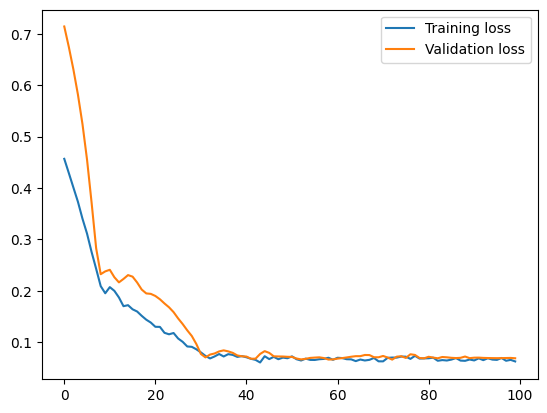

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

1/1 [==============================] - 1s 877ms/step
Reconstruction error threshold for test data: 0.12942596773306525


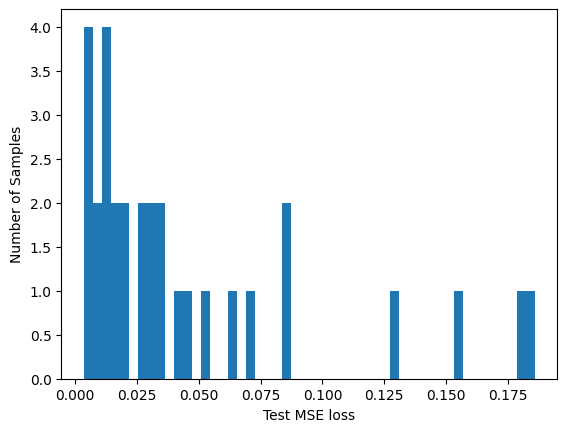

In [ ]:
# Predict on the test data
reconstructed_test_data = model.predict(X_test)

mae_loss_test = np.mean(np.abs(reconstructed_test_data - X_test), axis=(1, 2))

plt.hist(mae_loss_test, bins=50)
plt.xlabel('Test MSE loss')
plt.ylabel('Number of Samples')

# Calculate reconstruction error threshold for test data
threshold_test = np.percentile(mae_loss_test, 90)

print(f'Reconstruction error threshold for test data: {threshold_test}')



In [ ]:
print(mae_loss_test)

[0.01360645 0.01053532 0.12942597 0.00346053 0.07206366 0.08481317
 0.06504864 0.0523446  0.02976001 0.1858691  0.15597352 0.18119102
 0.08726144 0.01133918 0.00612482 0.02643932 0.00580725 0.01449295
 0.02719644 0.04268652 0.04496352 0.02929685 0.03398762 0.01360376
 0.01810947 0.01937899 0.00967484 0.03353857 0.01457514 0.01439691
 0.00407555]


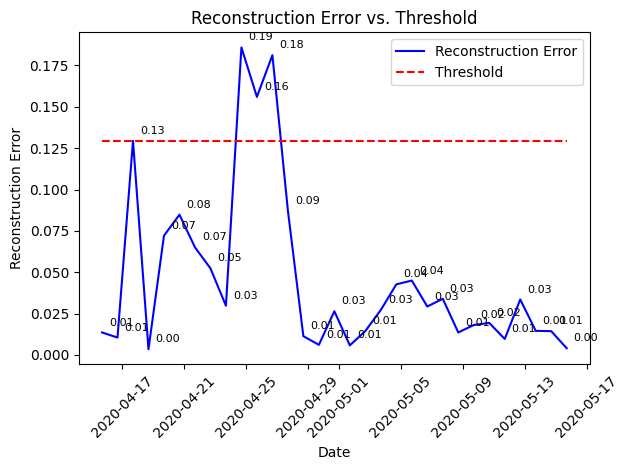

In [ ]:

reconstruction_errors = mae_loss_test

# Get the dates corresponding to the test data
test_dates = filtered_covid_ds.iloc[-len(reconstruction_errors):]['Date']

plt.plot(test_dates, reconstruction_errors, label='Reconstruction Error', color='blue')

# Plot the threshold line
threshold_line = [threshold_test] * len(reconstruction_errors)
plt.plot(test_dates, threshold_line, linestyle='--', color='red', label='Threshold')

plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs. Threshold')
plt.legend()

plt.xticks(rotation=45)

for date, error in zip(test_dates, reconstruction_errors):
    plt.annotate(f'{error:.2f}', xy=(date, error), xytext=(5, 5), textcoords='offset points', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()


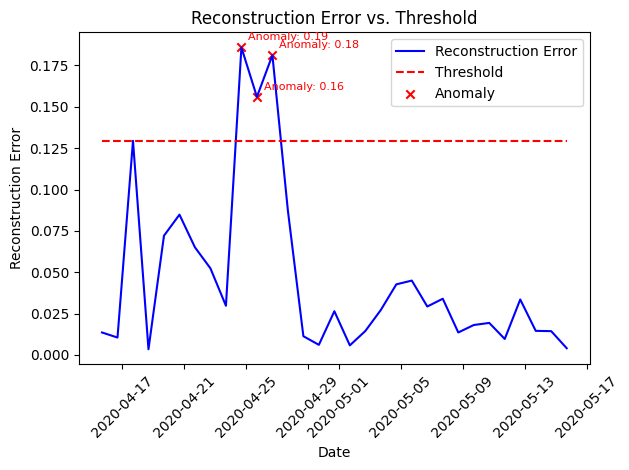

In [ ]:

reconstruction_errors = mae_loss_test

test_dates = filtered_covid_ds.iloc[-len(reconstruction_errors):]['Date']

plt.plot(test_dates, reconstruction_errors, label='Reconstruction Error', color='blue')

# Plot the threshold line
threshold_line = [threshold_test] * len(reconstruction_errors)
plt.plot(test_dates, threshold_line, linestyle='--', color='red', label='Threshold')

anomalies = reconstruction_errors > threshold_test

# Mark anomalies on the plot
anomaly_dates = test_dates[anomalies]
anomaly_errors = reconstruction_errors[anomalies]
plt.scatter(anomaly_dates, anomaly_errors, color='red', label='Anomaly', marker='x')

plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs. Threshold')
plt.legend()
plt.xticks(rotation=45)

# Annotate anomalies
for date, error in zip(anomaly_dates, anomaly_errors):
    plt.annotate(f'Anomaly: {error:.2f}', xy=(date, error), xytext=(5, 5), textcoords='offset points', fontsize=8, color='red')

plt.tight_layout()
plt.show()


In [ ]:
# Print dates where there is an anomaly
print("Dates with anomalies:")
for date in anomaly_dates:
    print(date)


Dates with anomalies:
2020-04-24 17:00:00
2020-04-25 17:00:00
2020-04-26 17:00:00


In [ ]:
# Filter original DataFrame for dates with anomalies
anomaly_data = filtered_covid_ds[filtered_covid_ds['Date'].isin(anomaly_dates)]

print("Original values of 'new_positive_cases' for dates with anomalies:")
print(anomaly_data[['Date', 'new_positive_cases']])



Original values of 'new_positive_cases' for dates with anomalies:
                    Date  new_positive_cases
1280 2020-04-24 17:00:00            0.586806
1301 2020-04-25 17:00:00            0.263889
1322 2020-04-26 17:00:00            0.121528
